## pyNX simulation example using 2D Images
- Objective: To reverse engineer the pynx.ptycho.simulation code to understand all of the simulation steps 
- To create a working 2D example for ANY image in the universe
- Once simulation is understood, deep-dive into phase-retrieval and reconstruction problem. (For now, just table the 3d problem. ONLY 2D problems are considered)

Here we are considering 2D ptychography using diffraction patterns simulated using images. 
---- We can also use CXI files for 3D CDI. ----

## 0. Import Libraries

In [1]:
import numpy as np
from numpy import pi
from scipy import misc
import sys
import timeit

from IPython import display
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as wg
import cv2
from pylab import *
%matplotlib inline

from pynx.ptycho import simulation, shape
from pynx.ptycho import *
from pynx.utils.pattern import siemens_star

/opt/miniconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## 1. Read any image

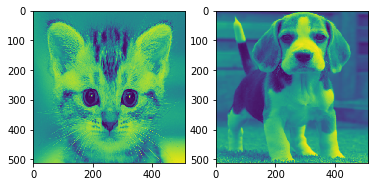

In [2]:
# 1.1 Amplitude image
# im = misc.face()
im = cv2.imread("American-shorthair-cat.jpg",0) # Reading color image as grayscale
resized_im = cv2.resize(im[400:1800, 900:2700], (512, 512)) # We will always fix the image size with dimensions divisible by 8
# resized_grayscaled_im = cv2.cvtColor(resized_im, cv2.COLOR_BGR2GRAY) # Convert RGB Channels to Grayscale for easier processing


# 1.2 Phase image
ph = misc.ascent()
ph = cv2.imread("maxresdefault.jpg",0)
resized_ph = cv2.resize(ph[0:719, 300:900], (512, 512)) # We will always fix the image size with dimensions divisible by 8
# resized_grayscaled_ph = cv2.cvtColor(resized_ph, cv2.COLOR_BGR2GRAY) # Convert RGB Channels to Grayscale for easier processing


# Plot the resized and gray-scaled image
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(resized_im)
ax2.imshow(resized_ph)
plt.show()

## 2. Simulate diffraction patterns for the image

In [3]:
##################
# Experimental settings
detector_distance = 1
wavelength = 1.5e-10
pixel_size_detector = 1e-6

# Simulation of the ptychographic data:
n = 256 # Probe pixels 256x256

# Stretch the phase to interval (-phase_stretch/2, +phase_stretch/2)
phase0 = resized_ph - resized_ph.min()
ps = 2 * np.pi
phase_stretch = ps * phase0 / phase0.max() - ps / 2.
obj = resized_im * np.exp(1j * phase_stretch)

# obj = resized_im + 1j * resized_ph # Convert the real space image to complex (Required to be fed into pyNX simulation)


### OBJECT INFORMATION
obj_info = {'type': 'phase_ampl', 'phase_stretch': pi / 2, 'alpha_win': .2}



### PROBE INFORMATION
probe_info = {'type': 'near_field', 'aperture': (80e-6, 80e-6), 'defocus': 0.5, 'shape': (n, n)}



### SCANNING METHODS (possible methods 'raster' and 'spiral')
# Here we scan 80 positions by moving the probe (moving the probe by 20 pixels after each scan and in a spiral fashion)
scan_info = {'type': 'spiral', 'scan_step_pix': 10, 'n_scans': 500}



### OUTPUT Diffraction data will depend upon the experimental settings like detector_distance(in m), wavelength of x-rays(in m), detector pixel-size(in m)
data_info = {'num_phot_max': 1e9, 'bg': 0, 'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector, 'noise': 'poisson', 'near_field': True}



### Initialisation of the simulation
# s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s = simulation.Simulation(obj=obj, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
# Data simulation: probe.show(), obj.show(), scan.show() and s.show_illumination_sum() will visualise the integrated total coverage of the beam
s.make_data()

posy, posx = s.scan.values
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity

Simulating probe: near_field
Simulating scan: spiral
Simulating ptychographic data [500 frames].
500 490 480 470 460 450 440 430 420 410 400 390 380 370 360 350 340 330 320 310 300 290 280 270 260 250 240 230 220 210 200 190 180 170 160 150 140 130 120 110 100 90 80 70 60 50 40 30 20 10 

Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': 1000000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 1e-06, 'near_field': True}
Scan info: {'type': 'spiral', 'scan_step_pix': 10, 'n_scans': 500, 'integer_values': True}
Object info: {'type': 'Custom', 'border_pix': 2}
Probe info: {'type': 'near_field', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (8e-05, 8e-05), 'defocus': 0.5}


amplitude_phase


/opt/miniconda3/lib/python3.7/site-packages/pynx/utils/plot_utils.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


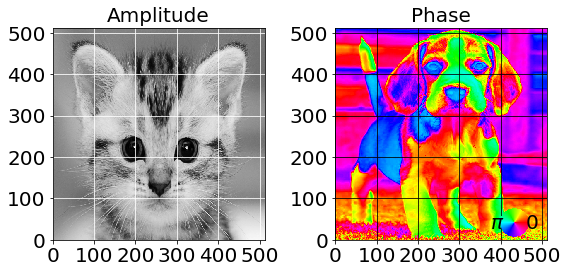

amplitude_phase


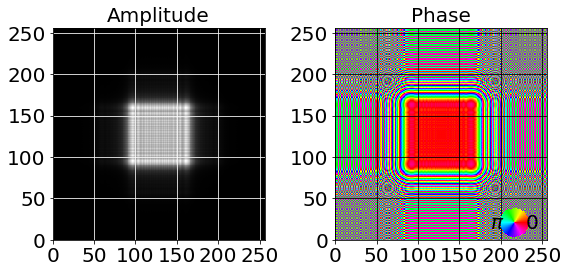

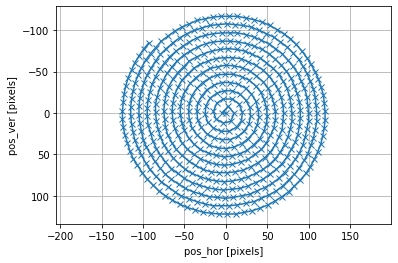

In [4]:
s.obj.show()
s.probe.show()
s.scan.show()

array([[6.37672865, 6.83733389, 6.67329923, ..., 7.11558294, 6.00635562,
        4.94164957],
       [6.47851118, 7.15383458, 6.9948509 , ..., 7.38832848, 6.26149359,
        3.33224022],
       [5.35659099, 6.45520014, 6.89467105, ..., 7.08840961, 6.88448768,
        5.81114399],
       ...,
       [5.83773336, 7.04838728, 7.34923147, ..., 7.18462991, 6.88038511,
        5.36598069],
       [4.8828095 , 5.66988437, 6.91075178, ..., 6.62406656, 6.94697695,
        6.42810689],
       [5.40268189, 5.05625217, 6.44094814, ..., 6.53379029, 6.60258925,
        6.46458986]])

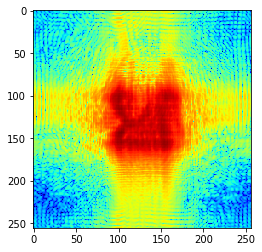

In [5]:
plt.imshow(np.log(np.abs(s.amplitude.values[0])**2 + 0.001),cmap='jet',vmin=0);
np.log(np.abs(s.amplitude.values[0])**2 + 0.001)

In [6]:
##################
# Evaluation:
# Size of the reconstructed object (obj)
nyo, nxo = shape.calc_obj_shape(posy, posx, ampl.shape[1:])

# Initial object
# obj_init_info = {'type':'flat','shape':(nx,ny)}
obj_init_info = {'type': 'random', 'range': (0, 1, 0, 0.5), 'shape': (nyo, nxo)}
# Initial probe
probe_init_info = {'type': 'near_field', 'aperture': (85e-6, 85e-6), 'defocus': 0.3, 'shape': (n, n)}
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)

init.make_obj()
init.make_probe()

data = PtychoData(iobs=ampl ** 2, positions=(posy * pixel_size_detector, posx * pixel_size_detector),
                  detector_distance=detector_distance, mask=None,
                  pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)

p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None)

# Initial scaling is important to avoid overflows during ML
p = ScaleObjProbe() * p

Simulating object: random
Simulating probe: near_field


## 3. Visualizing Diffraction patterns alongside probe position

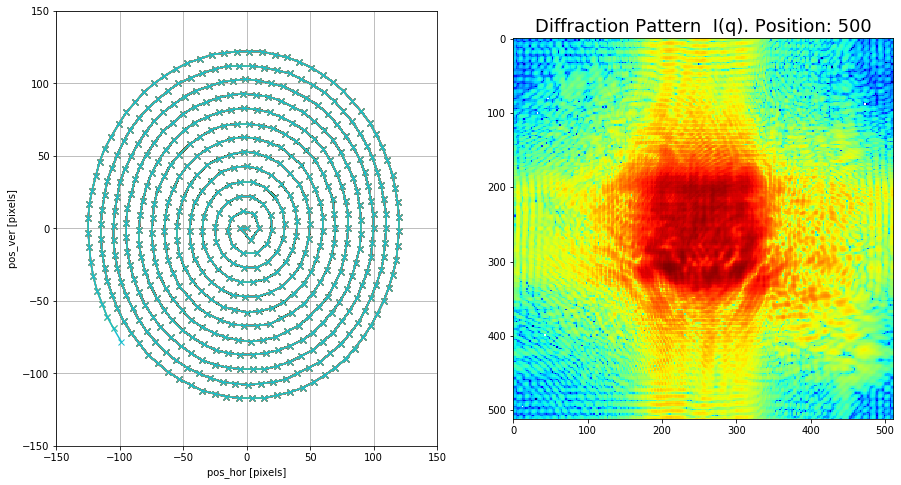

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

### Lets take a look at the diffraction patterns

im2 = ax2.imshow(resized_ph,cmap='jet',vmin=0)

# loop over the all of the positions
for ii in range(s.scan.info['n_scans']):
    ax1.plot(s.scan.values[1][:ii], s.scan.values[0][:ii], '-x')
    plt.axis('scaled')
    ax1.set_ylim([-150,150])
    ax1.set_xlim([-150,150])
    # ax1.gca().invert_yaxis()
    ax1.set_xlabel('pos_hor [pixels]')
    ax1.set_ylabel('pos_ver [pixels]')
    ax1.grid(b=True)

    amplitudes=s.amplitude.values[ii]
    ints=np.abs(amplitudes)**2
    im2.set_data(np.log(ints))
    ax2.set_title('Diffraction Pattern  I(q). Position: {}'.format(ii+1),fontsize=18)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.12)

In [8]:
def myplot(c):
    x = np.linspace(start=-10, stop=10, num=50)
    y = c * x**2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), dpi = 80, constrained_layout=True) # Constrained layout makes sure that the title texts don't overlap
    fig.suptitle('Scan position of probe(left) and Diffraction pattern(right)', fontsize=15)
    ax1.set_title("Spiral scan position"
                 , fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 20
                             , 'fontweight': 'medium'})
    # plt.axis('scaled')
    ax1.set_ylim([-150,150])
    ax1.set_xlim([-150,150])
    ax1.plot(s.scan.values[1][:c], s.scan.values[0][:c], '-x')
    ax1.set_xlabel('pos_hor [pixels]', fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 16
                             , 'fontweight': 'normal'})
    ax1.set_ylabel('pos_ver [pixels]', fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 16
                             , 'fontweight': 'normal'})
    ax1.grid(b=True)
    
    amplitudes=s.amplitude.values[c]
    ints=np.abs(amplitudes)**2
    im2 = ax2.imshow(np.log(ints + 0.0001),cmap='jet',vmin=0)
    ax2.set_title('Diffraction Pattern  I(q). Position: {}'.format(c+1),fontsize=18)
    
scan_number = wg.IntSlider(description = 'Scan Number:', min=0, max=s.scan.info['n_scans'])
wg.interact(myplot, c=scan_number);

interactive(children=(IntSlider(value=0, description='Scan Number:', max=500), Output()), _dom_classes=('widge…

In [9]:
p.data.iobs.shape

(500, 256, 256)

## 5. Phase retrieval and reconstruction

Difference Map optimization Initialized!
DM/o/p     #  0 LLK= 927191.42(p) 10060655.62(g) 1676749.70(e), nb photons=2.872031e+14, dt/cycle=1.885s


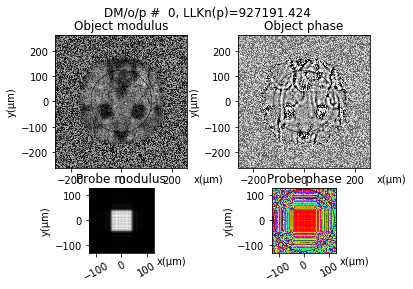

DM/o/p     # 10 LLK= 426718.98(p) 521670.88(g) 655204.86(e), nb photons=2.840727e+14, dt/cycle=0.149s
DM/o/p     # 20 LLK= 188357.79(p) 256339.01(g) 300441.66(e), nb photons=2.939435e+14, dt/cycle=0.082s
DM/o/p     # 30 LLK= 75889.94(p) 114419.67(g) 123247.86(e), nb photons=3.017254e+14, dt/cycle=0.082s
DM/o/p     # 40 LLK= 41098.12(p) 66004.74(g) 69040.84(e), nb photons=3.043962e+14, dt/cycle=0.082s
DM/o/p     # 50 LLK= 13985.83(p) 28592.32(g) 26744.49(e), nb photons=3.066439e+14, dt/cycle=0.082s
DM/o/p     # 60 LLK=  7412.82(p) 14856.02(g) 14401.78(e), nb photons=3.078386e+14, dt/cycle=0.082s
DM/o/p     # 70 LLK=  6773.75(p) 13561.12(g) 13019.25(e), nb photons=3.085140e+14, dt/cycle=0.082s
DM/o/p     # 80 LLK=  8238.06(p) 14737.00(g) 15217.51(e), nb photons=3.085992e+14, dt/cycle=0.082s
DM/o/p     # 90 LLK=  6827.94(p) 12843.17(g) 12794.49(e), nb photons=3.086129e+14, dt/cycle=0.082s
DM/o/p     #100 LLK=  5808.54(p) 10986.67(g) 10854.02(e), nb photons=3.086390e+14, dt/cycle=0.082s


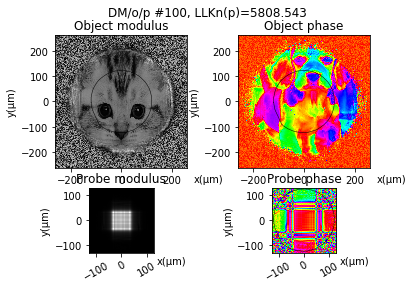

DM/o/p     #110 LLK=  2956.17(p)  5894.90(g)  5732.33(e), nb photons=3.088361e+14, dt/cycle=0.137s
DM/o/p     #120 LLK=  1571.98(p)  3135.66(g)  3103.21(e), nb photons=3.091209e+14, dt/cycle=0.082s
DM/o/p     #130 LLK=  1674.67(p)  3490.24(g)  3313.86(e), nb photons=3.093002e+14, dt/cycle=0.082s
DM/o/p     #140 LLK=  1974.89(p)  4184.45(g)  3892.66(e), nb photons=3.093335e+14, dt/cycle=0.082s
DM/o/p     #150 LLK=  1510.76(p)  3087.53(g)  2967.44(e), nb photons=3.093149e+14, dt/cycle=0.082s
DM/o/p     #160 LLK=   821.57(p)  1644.93(g)  1626.46(e), nb photons=3.093687e+14, dt/cycle=0.082s
DM/o/p     #170 LLK=   570.43(p)  1143.06(g)  1135.46(e), nb photons=3.094348e+14, dt/cycle=0.082s
DM/o/p     #180 LLK=   666.76(p)  1363.81(g)  1326.66(e), nb photons=3.094706e+14, dt/cycle=0.082s
DM/o/p     #190 LLK=   895.25(p)  1881.74(g)  1779.12(e), nb photons=3.094718e+14, dt/cycle=0.082s
DM/o/p     #199 LLK=   839.84(p)  1713.46(g)  1666.94(e), nb photons=3.094537e+14, dt/cycle=0.084s


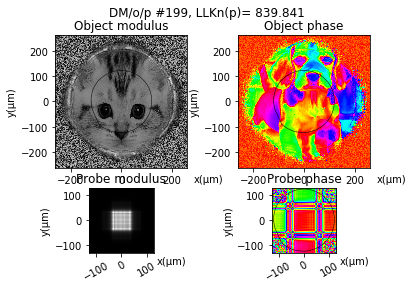

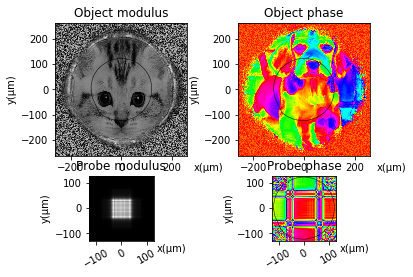

Difference Map optimization completed!
Alternating Projections optimization Initialized!
AP/o/p     #200 LLK=   839.56(p)  1713.74(g)  1666.57(e), nb photons=3.095297e+14, dt/cycle=0.076s


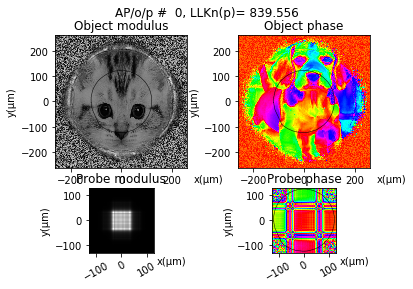

AP/o/p     #210 LLK=   724.69(p)  1509.77(g)  1445.29(e), nb photons=3.095337e+14, dt/cycle=0.116s
AP/o/p     #220 LLK=   654.65(p)  1359.86(g)  1305.72(e), nb photons=3.095319e+14, dt/cycle=0.063s
AP/o/p     #230 LLK=   594.33(p)  1231.27(g)  1185.49(e), nb photons=3.095304e+14, dt/cycle=0.063s
AP/o/p     #240 LLK=   541.58(p)  1119.26(g)  1080.35(e), nb photons=3.095294e+14, dt/cycle=0.063s
AP/o/p     #250 LLK=   495.05(p)  1020.77(g)   987.57(e), nb photons=3.095286e+14, dt/cycle=0.063s
AP/o/p     #260 LLK=   453.72(p)   933.58(g)   905.15(e), nb photons=3.095280e+14, dt/cycle=0.063s
AP/o/p     #270 LLK=   416.81(p)   855.96(g)   831.54(e), nb photons=3.095277e+14, dt/cycle=0.063s
AP/o/p     #280 LLK=   383.71(p)   786.56(g)   765.52(e), nb photons=3.095274e+14, dt/cycle=0.063s
AP/o/p     #290 LLK=   353.92(p)   724.27(g)   706.10(e), nb photons=3.095273e+14, dt/cycle=0.063s
AP/o/p     #300 LLK=   327.03(p)   668.16(g)   652.43(e), nb photons=3.095270e+14, dt/cycle=0.063s


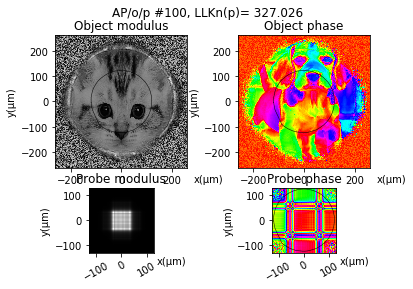

AP/o/p     #310 LLK=   302.66(p)   617.48(g)   603.82(e), nb photons=3.095269e+14, dt/cycle=0.119s
AP/o/p     #320 LLK=   280.55(p)   571.57(g)   559.68(e), nb photons=3.095270e+14, dt/cycle=0.063s
AP/o/p     #330 LLK=   260.42(p)   529.87(g)   519.51(e), nb photons=3.095270e+14, dt/cycle=0.063s
AP/o/p     #340 LLK=   242.06(p)   491.93(g)   482.86(e), nb photons=3.095270e+14, dt/cycle=0.063s
AP/o/p     #350 LLK=   225.29(p)   457.32(g)   449.37(e), nb photons=3.095270e+14, dt/cycle=0.063s
AP/o/p     #360 LLK=   209.93(p)   425.70(g)   418.71(e), nb photons=3.095271e+14, dt/cycle=0.063s
AP/o/p     #370 LLK=   195.85(p)   396.74(g)   390.59(e), nb photons=3.095272e+14, dt/cycle=0.063s
AP/o/p     #380 LLK=   182.91(p)   370.19(g)   364.75(e), nb photons=3.095273e+14, dt/cycle=0.063s
AP/o/p     #390 LLK=   171.01(p)   345.80(g)   340.98(e), nb photons=3.095274e+14, dt/cycle=0.063s
AP/o/p     #400 LLK=   160.05(p)   323.37(g)   319.09(e), nb photons=3.095276e+14, dt/cycle=0.063s


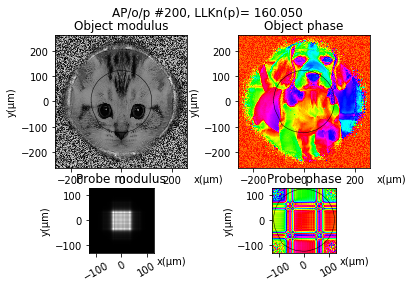

AP/o/p     #410 LLK=   149.94(p)   302.71(g)   298.89(e), nb photons=3.095276e+14, dt/cycle=0.117s
AP/o/p     #420 LLK=   140.60(p)   283.65(g)   280.24(e), nb photons=3.095277e+14, dt/cycle=0.063s
AP/o/p     #430 LLK=   131.97(p)   266.05(g)   262.99(e), nb photons=3.095278e+14, dt/cycle=0.063s
AP/o/p     #440 LLK=   123.98(p)   249.78(g)   247.02(e), nb photons=3.095279e+14, dt/cycle=0.063s
AP/o/p     #450 LLK=   116.58(p)   234.72(g)   232.23(e), nb photons=3.095280e+14, dt/cycle=0.063s
AP/o/p     #460 LLK=   109.72(p)   220.77(g)   218.52(e), nb photons=3.095281e+14, dt/cycle=0.063s
AP/o/p     #470 LLK=   103.35(p)   207.84(g)   205.78(e), nb photons=3.095282e+14, dt/cycle=0.063s
AP/o/p     #480 LLK=    97.44(p)   195.83(g)   193.96(e), nb photons=3.095283e+14, dt/cycle=0.063s
AP/o/p     #490 LLK=    91.94(p)   184.68(g)   182.96(e), nb photons=3.095283e+14, dt/cycle=0.063s
AP/o/p     #500 LLK=    86.82(p)   174.31(g)   172.73(e), nb photons=3.095284e+14, dt/cycle=0.063s


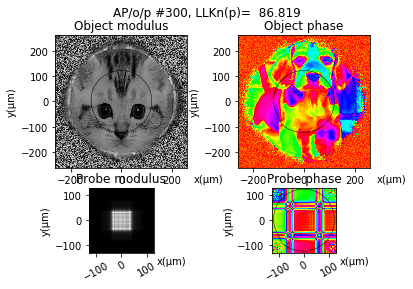

AP/o/p     #510 LLK=    82.06(p)   164.67(g)   163.20(e), nb photons=3.095286e+14, dt/cycle=0.117s
AP/o/p     #520 LLK=    77.62(p)   155.69(g)   154.33(e), nb photons=3.095286e+14, dt/cycle=0.063s
AP/o/p     #530 LLK=    73.48(p)   147.32(g)   146.06(e), nb photons=3.095286e+14, dt/cycle=0.063s
AP/o/p     #540 LLK=    69.63(p)   139.52(g)   138.34(e), nb photons=3.095286e+14, dt/cycle=0.063s
AP/o/p     #550 LLK=    66.02(p)   132.25(g)   131.14(e), nb photons=3.095287e+14, dt/cycle=0.063s
AP/o/p     #560 LLK=    62.66(p)   125.46(g)   124.41(e), nb photons=3.095287e+14, dt/cycle=0.063s
AP/o/p     #570 LLK=    59.52(p)   119.12(g)   118.12(e), nb photons=3.095289e+14, dt/cycle=0.063s
AP/o/p     #580 LLK=    56.59(p)   113.19(g)   112.25(e), nb photons=3.095289e+14, dt/cycle=0.063s
AP/o/p     #590 LLK=    53.84(p)   107.65(g)   106.75(e), nb photons=3.095289e+14, dt/cycle=0.063s
AP/o/p     #599 LLK=    51.52(p)   102.97(g)   102.11(e), nb photons=3.095290e+14, dt/cycle=0.063s


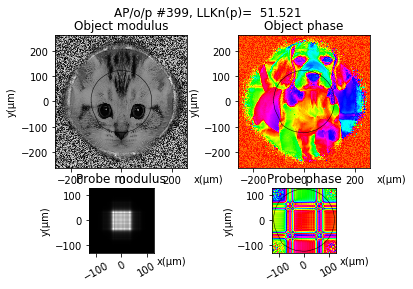

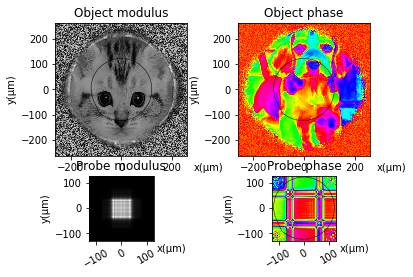

Alternating Projections optimization completed!
Maximum likelihood optimization Initialized!
ML/o/p     #601 LLK=    51.02(p)   101.97(g)   101.12(e), nb photons=3.095290e+14, dt/cycle=0.998s


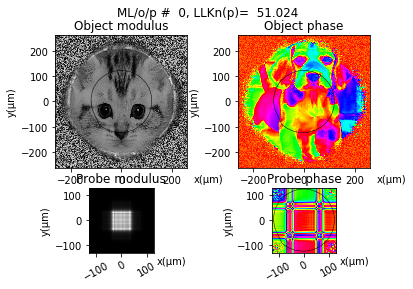

ML/o/p     #611 LLK=    27.64(p)    54.91(g)    54.26(e), nb photons=3.095341e+14, dt/cycle=0.227s
ML/o/p     #621 LLK=    22.34(p)    44.25(g)    43.60(e), nb photons=3.095301e+14, dt/cycle=0.170s
ML/o/p     #631 LLK=    19.94(p)    39.40(g)    38.76(e), nb photons=3.095308e+14, dt/cycle=0.173s
ML/o/p     #641 LLK=    18.94(p)    37.39(g)    36.76(e), nb photons=3.095320e+14, dt/cycle=0.169s
ML/o/p     #651 LLK=    18.22(p)    35.94(g)    35.32(e), nb photons=3.095319e+14, dt/cycle=0.170s
ML/o/p     #661 LLK=    17.54(p)    34.57(g)    33.95(e), nb photons=3.095325e+14, dt/cycle=0.169s
ML/o/p     #671 LLK=    16.98(p)    33.43(g)    32.82(e), nb photons=3.095309e+14, dt/cycle=0.172s
ML/o/p     #681 LLK=    16.62(p)    32.72(g)    32.11(e), nb photons=3.095299e+14, dt/cycle=0.169s
ML/o/p     #691 LLK=    15.90(p)    31.27(g)    30.67(e), nb photons=3.095309e+14, dt/cycle=0.171s
ML/o/p     #700 LLK=    15.28(p)    30.00(g)    29.42(e), nb photons=3.095276e+14, dt/cycle=0.170s


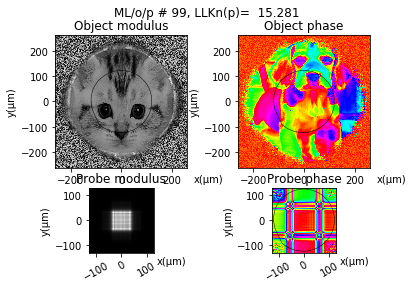

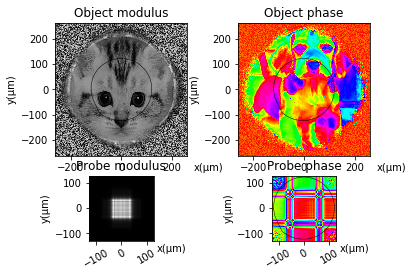

Maximum likelihood optimization completed!


In [10]:
%matplotlib inline
print("Difference Map optimization Initialized!")
p = ShowObjProbe(fig_num=1) * DM(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=100) ** 200 * p
print("Difference Map optimization completed!\nAlternating Projections optimization Initialized!")
p = ShowObjProbe(fig_num=1) * AP(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=100) ** 400 * p
print("Alternating Projections optimization completed!\nMaximum likelihood optimization Initialized!")
p = ShowObjProbe(fig_num=1) * ML(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=100) ** 100 * p
print("Maximum likelihood optimization completed!")

In [11]:
p.get_obj().shape

(1, 524, 520)